<a href="https://colab.research.google.com/github/ezgimez/dl-demos/blob/main/demo5_modified.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Finetuning and Understanding ResNet

Modern deep convnets tend to have tens (if not hundreds) of layers, with millions (if not tens of millions) of trainable parameters. More often than not several of these layers have skipped connections; the *ResNet* family of networks are an example. 

The flip side of having such deep network architectures is that to properly learn such networks, one requires *massive* amounts of training data. In most applications, access to such massive datasets simply isn't available; gathering and curating a dataset with a few hundred/thousand examples itself can be a challenge.

What should one do in the ``small data'' setting? A possible solution:
* start with a deep network architecture initialized with *pre-trained* weights, and
* *fine-tune* the network weights on the (small) training dataset.

In this demo we will see how to train a simple cat-vs-dog classifier using a very small training dataset of 60 images. The dataset is provided [here](https://github.com/chinmayhegde/dl-demos/blob/main/data.zip). You can unzip and save the dataset anywhere you like; I've saved it to my Google drive folder: `content/`. (You can easily find out about the path doing: copy the path location from the table of contents on the left side by clicking the dot menu on RHS of some folder -> copy path.)


In [16]:
! pip install d2l==0.17.2
# you might need to restart your runtime after this installation.
# just follow the steps that pops up at the end of downloads..
# we need this for running Dive into Deep Learning scripts (towards the end of the notebook)

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt

In [2]:
! pwd # printing working directory

/content


In [3]:
! unzip data.zip # unzips

Archive:  data.zip
replace data/train/cat/11.jpeg? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [5]:
# data transforms
dset_transform = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])])


# Use the image folder function to create datasets
dsets = {x: datasets.ImageFolder(f"/content/data/{x}", dset_transform)
         for x in ['train', 'val']}

# create data loader
dataloaders = {x: torch.utils.data.DataLoader(dsets[x], batch_size=16,
                                              shuffle=(x == "train"))
               for x in ['train', 'val']}


# Loading a pre-trained ResNet model

Let's load a ResNet34 model from `torchvision` and examine it.

In [6]:
# intialize model
model = models.resnet34(pretrained=True)

Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth


  0%|          | 0.00/83.3M [00:00<?, ?B/s]

In [ ]:
print(model)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

Hmm, lots of layers. Each `BasicBlock` is two or three conv layers with a skipped connection, with batch-norm layers thrown in for good measure. Several such residual blocks are pieced together, and in the end there is a dense layer with 1000 output neurons. This model has been trained on the well-known *ImageNet* dataset (which has over a million images with 1000 classes). As an aside, let's examine the number of trainable parameters in the model.

In [7]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)
    # torch.numel() returns number of elements in a tensor

print(count_parameters(model))

21797672


Let us finetune this model for our cat-vs-dog classification problem. Since this is a binary classifier we will redefine the output (linear) layer to have 2 outputs.

In [8]:
num_ftrs = model.fc.in_features
print(num_ftrs)
# this is also listed above in the last layer of ResNet info printout

512


In [9]:
model.fc = nn.Linear(num_ftrs, 2) # redefine the last fc layer according to our problem setup

In [10]:
print(model)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

Observe now that the basic ResNet34 backbone remains the same; only the output layer has changed. In fact, all of the weights (except the output layer) also have been retained.  

Let's do a quick model evaluation to check if there are any errors thrown during prediction.

In [12]:
model.eval()
corrects = 0
for batch_idx, (inputs,labels) in enumerate(dataloaders['val'], 1):
  with torch.set_grad_enabled(False):
    outputs = model(inputs)
    #print(outputs.shape)
    _, preds = torch.max(outputs,1)
    
  corrects += torch.sum(preds == labels.data)

print(corrects.float() / len(dataloaders['val'].dataset))

tensor(0.2917)


As we can see, we get a low accuracy on the validation set -- which is exactly what we would expect since the weights of the output layer are random in the last layer that we have just defined. 

We are now ready to start fine-tuning! The rest of the code below is boilerplate training; we see below that only a few epochs are enough to tune the weights to our training dataset.  

In [14]:
# define loss function, optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
save_loss = {'train':[], 'val':[]}
save_acc = {'train':[], 'val':[]}

In [15]:
for epoch in range(5):

    # Each epoch has a training and validation phase
    for phase in ['train', 'val']:
        if phase == 'train':
            model.train()  # Set model to training mode
        else:
            model.eval()   # Set model to evaluate mode

        current_loss = 0.0
        current_corrects = 0

        for batch_idx, (inputs, labels) in enumerate(dataloaders[phase], 1):
            optimizer.zero_grad()

            # Time to carry out the forward training poss
            with torch.set_grad_enabled(phase == 'train'):
                outputs = model(inputs)
                _, preds = torch.max(outputs, 1)
                loss = criterion(outputs, labels)

                # backward + optimize only if in training phase
                if phase == 'train':
                    loss.backward()
                    optimizer.step()

            # We want variables to hold the loss/acc statistics
            current_loss += loss.item() * inputs.size(0)
            current_corrects += torch.sum(preds == labels.data)
        # saving variable for plottin
        save_loss[phase] += [current_loss / len(dataloaders[phase].dataset)]
        save_acc[phase] += [current_corrects.float() / len(dataloaders[phase].dataset)]

        # pretty print
        print(f"Epoch:{epoch} -- Phase:{phase} -- Loss:{save_loss[phase][-1]:.2f} -- Acc:{save_acc[phase][-1]*100:.2f}")


Epoch:0 -- Phase:train -- Loss:0.71 -- Acc:56.67
Epoch:0 -- Phase:val -- Loss:0.53 -- Acc:79.17
Epoch:1 -- Phase:train -- Loss:0.39 -- Acc:91.67
Epoch:1 -- Phase:val -- Loss:0.24 -- Acc:100.00
Epoch:2 -- Phase:train -- Loss:0.17 -- Acc:98.33
Epoch:2 -- Phase:val -- Loss:0.11 -- Acc:100.00
Epoch:3 -- Phase:train -- Loss:0.11 -- Acc:100.00
Epoch:3 -- Phase:val -- Loss:0.07 -- Acc:100.00
Epoch:4 -- Phase:train -- Loss:0.06 -- Acc:100.00
Epoch:4 -- Phase:val -- Loss:0.04 -- Acc:100.00


Text(0.5, 1.0, 'Accuracy')

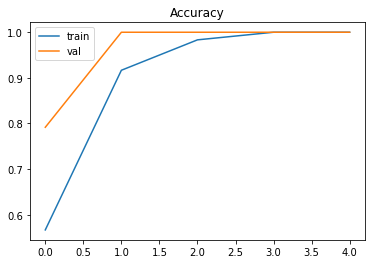

In [16]:
plt.plot(save_acc['train'])
plt.plot(save_acc['val'])
plt.legend(["train", "val"])
plt.title("Accuracy")


There we go! That took only 4 epochs of finetuning.

This was a very small dataset (of only 60 training images) so it is not that surprising that we were able to fit the data so easily. Try training your own classifier with a slightly larger set of data points, and see if you can get similar results.

Let's now into analyse ResNet architecture in more detail. The rest of the notebook is adopted from [Dive into Deep Learning](https://https://d2l.ai/chapter_convolutional-modern/resnet.html).

ResNet's architecture is similar to VGG's: full  of 3×3  convolutional layers. The residual block has two  3×3  convolutional layers with the same number of output channels. Each convolutional layer is followed by a batch normalization layer and a ReLU activation function (see the below code to confirm this). Then, we skip these two convolution operations and add the input directly before the final ReLU activation function (again see the code below!). This kind of design requires that the output of the two convolutional layers has to be of the same shape as the input, so that they can be added together (otherwise, simply dimensions do not match..). If we want to change the number of channels, we need to introduce an additional  1×1  convolutional layer to transform the input into the desired shape for the addition operation (see `self.conv3` in the code below). Let's check the code.

In [5]:
import torch
from torch import nn
from torch.nn import functional as F
from d2l import torch as d2l


class Residual(nn.Module):  
    """The Residual block of ResNet."""
    def __init__(self, input_channels, num_channels,
                 use_1x1conv=False, strides=1):
        super().__init__()
        self.conv1 = nn.Conv2d(input_channels, num_channels,
                               kernel_size=3, padding=1, stride=strides)
        self.conv2 = nn.Conv2d(num_channels, num_channels,
                               kernel_size=3, padding=1)
        if use_1x1conv:
            self.conv3 = nn.Conv2d(input_channels, num_channels,
                                   kernel_size=1, stride=strides)
        else:
            self.conv3 = None
        self.bn1 = nn.BatchNorm2d(num_channels)
        self.bn2 = nn.BatchNorm2d(num_channels)

    def forward(self, X):
        Y = F.relu(self.bn1(self.conv1(X)))
        Y = self.bn2(self.conv2(Y))
        if self.conv3:
            X = self.conv3(X)
        Y += X
        return F.relu(Y)

Note that instead of `F.relu()` you could have also used `nn.RelU()` in the code above. Check the explanation [here](https://discuss.pytorch.org/t/whats-the-difference-between-nn-relu-vs-f-relu/27599).

(Think about why you can do this -- are you learning anything with respect to ReLU in backpropogation?)

Following is the situation where the input and output are of the same dimension. (Why?)



In [14]:
blk = Residual(3,3)
X = torch.rand(4, 3, 6, 6)
Y = blk(X)
Y.shape
# https://pytorch.org/docs/stable/generated/torch.nn.Conv2d.html 
# here is the documentation about input/output shapes of nn.Conv2d()

torch.Size([4, 3, 6, 6])

We can easily decrease the output's height and width while increasing the number of output channels as follows.

In [15]:
blk = Residual(3, 6, use_1x1conv=True, strides=2)
blk(X).shape
# since we are changing the number of channels from 3 to 6, 
# we have use_1x1conv=True

torch.Size([4, 6, 3, 3])

You can follow the rest of the Dive into Deep Learning notebook from [here](https://d2l.ai/chapter_convolutional-modern/resnet.html).